In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.losses import mse
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [ ]:
# Load NAB dataset (replace 'path_to_nab_data.csv' with the actual path)
train_data = pd.read_csv('art_daily_no_noise.csv')
test_data = pd.read_csv('art_daily_nojump.csv')

# Assume the dataset has a 'value' column with the time series data
# If the dataset contains other columns, you can select only the relevant ones
train_values = train_data['value'].values.reshape(-1, 1)
test_values = test_data['value'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
train_values_scaled = scaler.fit_transform(train_values)
test_values_scaled = scaler.fit_transform(test_values)

# Define the input dimension based on your data
input_dim = train_values_scaled.shape[1]

# Split the data into training and testing sets (you can customize the split ratio)
#split_ratio = 0.8
#train_size = int(len(values_scaled) * split_ratio)
x_train, x_test = train_values_scaled[:], test_values_scaled[:]


In [ ]:
x_test.shape, x_train.shape

((4032, 1), (4032, 1))

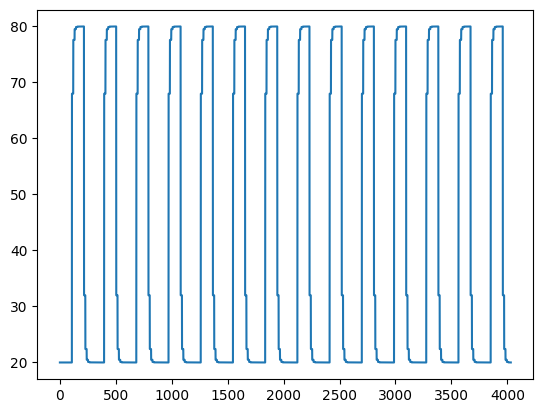

In [ ]:
plt.plot(train_values)

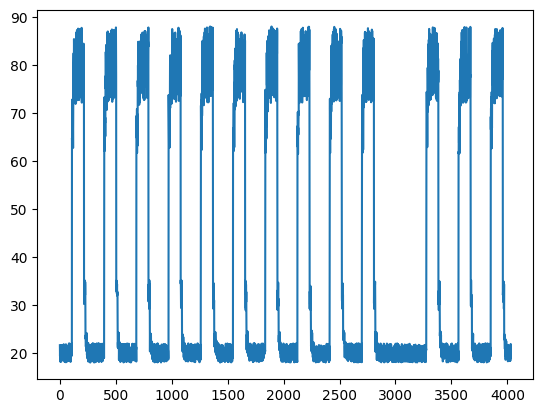

In [ ]:
plt.plot(test_values)

In [ ]:
# Define the VAE components
latent_dim = 2  # Latent space dimensionality

# Encoder
encoder_inputs = layers.Input(shape=(input_dim,))
x = layers.Dense(64, activation='relu')(encoder_inputs)
x = layers.Dense(32, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(32, activation='relu')(latent_inputs)
x = layers.Dense(64, activation='relu')(x)
decoder_outputs = layers.Dense(input_dim, activation='sigmoid')(x)

decoder = models.Model(latent_inputs, decoder_outputs, name="decoder")

# VAE model
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        self.add_loss(kl_loss)
        return reconstructed

vae = VAE(encoder, decoder)
vae.compile(optimizer='adam', loss=mse)

# Train the VAE on NAB data
vae.fit(x_train, x_train, epochs=30, batch_size=128, validation_data=(x_test, x_test))


Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.4996 - val_loss: 0.1632
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2160 - val_loss: 0.1638
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2193 - val_loss: 0.1605
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2176 - val_loss: 0.1605
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2189 - val_loss: 0.1597
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2165 - val_loss: 0.1599
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2155 - val_loss: 0.1591
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2181 - val_loss: 0.1595
Epoch 9/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2177 - val_loss: 0.1602
Epoch 10/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2178 - val_loss: 0.1591
Epoch 11/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2159 - val_loss: 0.1584
Epoch 12/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2170 - val_l

In [ ]:
# Reconstruct the test data using the VAE
reconstructed = vae.predict(x_test)

# Compute the reconstruction error
reconstruction_error = np.mean(np.square(x_test - reconstructed), axis=1)

# Set a threshold for anomaly detection (e.g., the 95th percentile of the reconstruction error)
threshold = np.percentile(reconstruction_error, 95)
anomalies = reconstruction_error > threshold

print(f"Detected {np.sum(anomalies)} anomalies in the test set.")


126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Detected 202 anomalies in the test set.
